In [3]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

ModuleNotFoundError: No module named 'mne'

In [4]:
def get_window(raw, annotation):
    window = raw.copy().crop(tmin=annotation['onset'], tmax=annotation['onset']+annotation['duration'])
    
    return window

def get_window_dict(raw, annotations):
    window_dict = {}

    for description in np.unique(annotations.description):

        list_of_windows = []
        for annotation in annotations[annotations.description==description]:
            list_of_windows.append(get_window(raw, annotation))

        window_dict[description] = list_of_windows

    return window_dict

In [5]:
edf_file_path = 'notebooks/S001R03.edf'
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

NameError: name 'get_fsaverage' is not defined

In [85]:
raw = get_raw(edf_file_path, filter=True)
annotations = get_annotations(edf_file_path)
annotation_dict = get_window_dict(raw, annotations)

In [86]:
window = annotation_dict['T1'][1]

In [163]:
src = get_src(src_path)
fwd = get_fwd(raw.info, trans, src_path, bem_path)
cov = get_cov(raw)
stc = get_stc(window, fwd, cov, snr=0.1)

In [166]:
parcellation_name = "HCPMMP1_combined"
labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

In [167]:
vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

In [168]:
#activity = get_power_per_label(stc, labels)
values = np.sum(stc.data**2, axis=1).reshape(2, 10242) #activity_to_source_values(activity, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

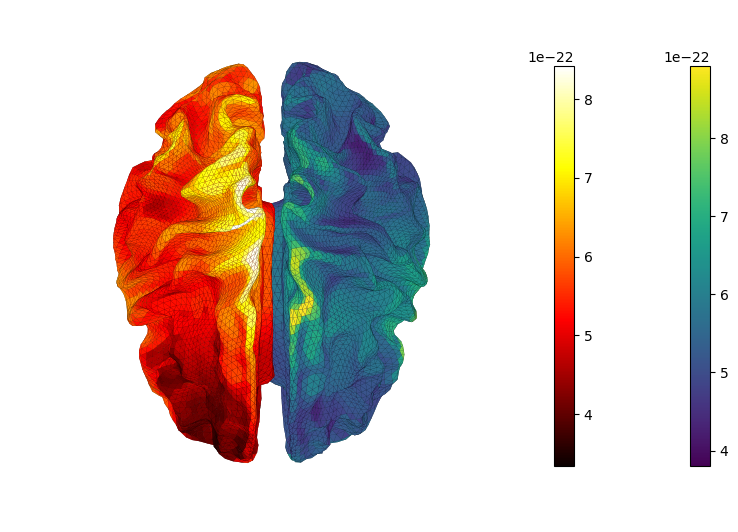

In [169]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="viridis")

lh_mesh.set_array(tris_values[0])
fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, 90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.show()

In [170]:
stc.plot()

Using control points [1.63886455e-12 1.78014757e-12 2.86837542e-12]


In [171]:
for i in range(len(labels[0])):
    lh_idx = np.argsort(activity[0])[::-1][i]
    rh_idx = np.argsort(activity[1])[::-1][i]
    lh_name = labels[0][lh_idx].name
    rh_name = labels[1][rh_idx].name
    print('{0:.2f} {1:55}  {2:.2f} {3}'.format(activity[0][lh_idx], lh_name, activity[1][rh_idx], rh_name))

1.00 Lateral Temporal Cortex-lh                               0.98 Lateral Temporal Cortex-rh
0.99 Auditory Association Cortex-lh                           0.95 Paracentral Lobular and Mid Cingulate Cortex-rh
0.91 Premotor Cortex-lh                                       0.95 Inferior Frontal Cortex-rh
0.81 Posterior Opercular Cortex-lh                            0.89 Auditory Association Cortex-rh
0.79 Paracentral Lobular and Mid Cingulate Cortex-lh          0.86 Early Visual Cortex-rh
0.77 Inferior Frontal Cortex-lh                               0.82 Somatosensory and Motor Cortex-rh
0.76 Early Visual Cortex-lh                                   0.80 Primary Visual Cortex (V1)-rh
0.71 MT+ Complex and Neighboring Visual Areas-lh              0.80 MT+ Complex and Neighboring Visual Areas-rh
0.70 Primary Visual Cortex (V1)-lh                            0.79 Premotor Cortex-rh
0.69 DorsoLateral Prefrontal Cortex-lh                        0.76 Superior Parietal Cortex-rh
0.68 Somatosensory 

In [161]:
print([labels[0][i].name for i in range(len(labels[0]))])

['???-lh', 'Anterior Cingulate and Medial Prefrontal Cortex-lh', 'Auditory Association Cortex-lh', 'Dorsal Stream Visual Cortex-lh', 'DorsoLateral Prefrontal Cortex-lh', 'Early Auditory Cortex-lh', 'Early Visual Cortex-lh', 'Inferior Frontal Cortex-lh', 'Inferior Parietal Cortex-lh', 'Insular and Frontal Opercular Cortex-lh', 'Lateral Temporal Cortex-lh', 'MT+ Complex and Neighboring Visual Areas-lh', 'Medial Temporal Cortex-lh', 'Orbital and Polar Frontal Cortex-lh', 'Paracentral Lobular and Mid Cingulate Cortex-lh', 'Posterior Cingulate Cortex-lh', 'Posterior Opercular Cortex-lh', 'Premotor Cortex-lh', 'Primary Visual Cortex (V1)-lh', 'Somatosensory and Motor Cortex-lh', 'Superior Parietal Cortex-lh', 'Temporo-Parieto-Occipital Junction-lh', 'Ventral Stream Visual Cortex-lh']
